In [1]:
# load all test_articles in
import os

test_article_dir = "../test_articles"

articles_map: dict[str, str] = {}

for article_path in os.listdir(test_article_dir):
    full_article_path = os.path.join(test_article_dir, article_path)
    with open(full_article_path, "r", encoding="utf-8") as file:
        articles_map[article_path[:-3]] = file.read()

In [19]:
import numpy as np
from sentence_transformers import SentenceTransformer
from functools import cache

model = SentenceTransformer("all-MiniLM-L6-v2")

def cosine_similarity(vec1, vec2):
    """
    Calculate the cosine similarity between two vectors.

    Parameters:
    vec1 (numpy.ndarray): First vector.
    vec2 (numpy.ndarray): Second vector.

    Returns:
    float: Cosine similarity between vec1 and vec2.
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

@cache
def vectorize(sentence):
    embeddings = model.encode(sentence)
    return np.array(embeddings)


title_vectors: dict[str, np.array] = {}
for i, title in enumerate(articles_map.keys()):
    title_vectors[title] = vectorize(title)
    print(f"{i / len(articles_map) * 100:.2f}%", end="\r")
print("Finished.")

Finished.


In [ ]:
def tokenize(sentence: str) -> list[str]:
    return sentence.split(" ")

article_backlinks: dict[str, list[str]] = {}
all_titles = list(articles_map.keys())
title_tokenizations = {t: tokenize(t) for t in all_titles}
single_word_titles = [t for t in all_titles if len(title_tokenizations[t]) == 1]

similarity_thresh = 0.8

def parse_article(title: str, content: str):
    words = tokenize(content)
    backlinks: list[tuple[str, str]] = []

    # find 1 word matches
    for word in words:
        word_vec = vectorize(word)
        for title in single_word_titles:
            title_vec = title_vectors[title]
            if cosine_similarity(word_vec, title_vec) >= similarity_thresh:
                backlinks.append((word, title))

    # find 2 word matches
    for word, next_word in zip(words, words[1:]):
        query = f"{word} {next_word}"
        query_vec = vectorize(word)
        for title in all_titles:
            title_vec = title_vectors[title]
            if cosine_similarity(query_vec, title_vec) >= similarity_thresh:
                backlinks.append((query, title))

    return backlinks

for i, title in enumerate(articles_map.keys()):
    content = articles_map[title]
    backlinks = parse_article(title, content)
    article_backlinks[title] = backlinks
    print(f"{i / len(articles_map) * 100:.2f}%", end="\r")
print("Finished.")

Finished.


In [ ]:
class Node:

    def __init__(self, title, edges=None):
        self.title = title
        self.edges: list["Node"] = edges if edges is not None else list()

article_node_map = {}
for title in all_titles:
    article_node_map[title] = Node(title)

all_nodes: list[Node] = list(article_node_map.values())

for node in all_nodes:
    backlinks = article_backlinks[node.title]
    outlinks = set(b[1] for b in backlinks)
    for other_node in all_nodes:
        if node.title == other_node.title:
            continue
        if other_node.title in outlinks:
            node.edges.append(other_node)
        


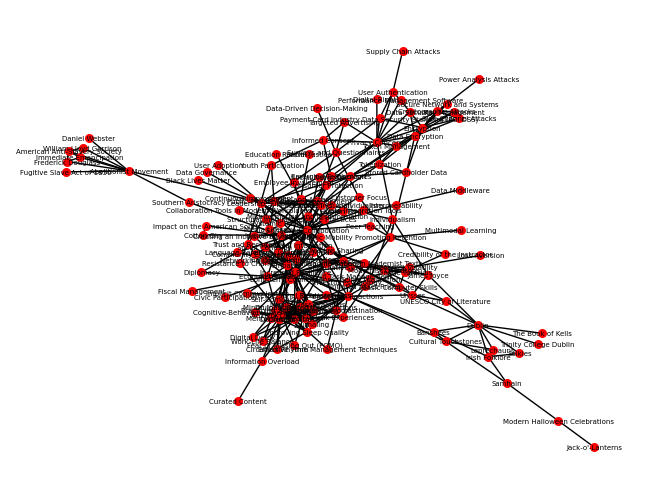

In [46]:
import networkx as nx

node_ids = {node.title: node.title for i, node in enumerate(all_nodes)}

G = nx.Graph()
for node in all_nodes:
    if len(node.edges) == 0:
        continue
    G.add_node(node_ids[node.title])
    for edge in node.edges:
        G.add_edge(node_ids[node.title], node_ids[edge.title])

nx.draw(G, node_size=30, font_size=5, with_labels=True, node_color="red")

{'Abolitionist Movement': 'Abolitionist Movement',
 'Active Listening': 'Active Listening',
 'American Anti-Slavery Society': 'American Anti-Slavery Society',
 'Anxiety Disorders': 'Anxiety Disorders',
 'Banshees': 'Banshees',
 'Basic Computer Skills': 'Basic Computer Skills',
 'Black Lives Matter': 'Black Lives Matter',
 'Career Development': 'Career Development',
 'Chronic Stress': 'Chronic Stress',
 'Circadian Rhythm': 'Circadian Rhythm',
 'Civic Participation': 'Civic Participation',
 'Cognitive-Behavioral Therapy (CBT)': 'Cognitive-Behavioral Therapy (CBT)',
 'Collaboration Tools in Modern Workplaces': 'Collaboration Tools in Modern Workplaces',
 'Collaborative Innovations': 'Collaborative Innovations',
 'Collectivism vs. Individualism': 'Collectivism vs. Individualism',
 'Community Engagement': 'Community Engagement',
 'Consumer Protection': 'Consumer Protection',
 'Continuous Improvement': 'Continuous Improvement',
 'Cotton Gin': 'Cotton Gin',
 'Creating an Inclusive Environment